In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gurobipy as gp
from sklearn.linear_model import LassoCV
from sklearn.model_selection import KFold
%matplotlib inline

## Importing Train and test sets

In [2]:
train = pd.read_csv("training_data.csv")
train.insert(1, 'X0', [1]*len(train))
test = pd.read_csv("test_data.csv")
test.insert(1, 'X0', [1]*len(test))
train.shape, test.shape

((250, 52), (50, 52))

In [3]:
train.head()

,y,X0,X1,X2,X3,X4,X5,X6,X7,X8,...,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50
0,8.536145,1,-1.535413,0.718888,-2.099149,-0.442842,-0.598978,-1.642574,0.207755,0.760642,...,0.361866,1.793098,-0.631287,-0.061751,0.511049,0.488754,-0.612772,-0.471045,-1.139781,-0.260773
1,4.808344,1,-1.734609,0.551981,-2.147673,-1.552944,1.514910,-1.143972,0.737594,1.321243,...,-0.677985,-0.165679,0.065405,0.137162,1.258197,-0.120834,-1.564834,-0.242565,-0.001827,1.187453
2,-1.530427,1,0.097257,0.107634,-0.194222,0.335454,-0.408199,0.133265,0.706179,0.394971,...,1.108801,0.333791,0.282055,-1.086294,-0.115354,0.257857,-0.088838,-0.751231,1.450609,0.290593
3,-0.428243,1,-0.067702,0.557836,0.700848,-1.121376,1.722274,0.613525,0.700909,-0.417976,...,0.692511,-0.350990,0.624558,0.434520,-0.367409,-1.144681,-0.136524,-0.557214,0.416303,0.484495
4,0.566694,1,0.488729,0.211483,0.568389,0.646837,0.163868,-0.002152,0.125137,0.493571,...,-0.000605,1.075280,0.182281,-1.138458,0.106092,0.544640,-0.383487,-0.425773,2.667647,-0.050748


# Shuffling training set

In [4]:
train = train.sample(frac=1,random_state=100).reset_index(drop=True)

In [5]:
train.head()

,y,X0,X1,X2,X3,X4,X5,X6,X7,X8,...,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50
0,8.929452,1,-1.095317,0.577923,-1.606984,-0.062336,0.143991,1.360918,-0.815264,0.357488,...,-0.149673,0.592354,1.048049,2.314745,1.097569,-2.386451,-1.338940,0.290801,0.414236,0.866780
1,-5.799633,1,-0.702044,-0.759860,0.632934,2.193968,0.702947,-1.908253,1.207841,0.149813,...,-0.488370,0.640200,0.402177,-0.962255,-2.170478,-0.480307,1.460908,-0.732313,1.660601,-0.338892
2,5.948323,1,-0.986549,0.024756,-0.148764,1.466318,1.282209,0.295801,-1.182817,-0.932046,...,0.389020,1.642970,0.916629,-0.102821,-0.051025,-0.046690,0.286985,0.640431,-0.056373,0.353986
3,3.807360,1,0.200424,0.189315,-0.905100,-2.854128,1.319839,1.724242,-1.311053,-0.556105,...,-1.332689,-0.585949,0.927983,1.589170,2.029222,1.220493,-2.512068,0.392134,-0.779833,-1.001974
4,-3.351793,1,-0.404082,-0.669650,-1.833165,0.093195,0.871184,-0.124164,0.150745,-0.783834,...,-0.186963,-0.907139,0.000460,-0.644975,-1.261780,-0.118846,-1.940222,-0.901357,1.010079,-0.592381


## Cross Validation Split

In [6]:
# Split a dataset into k folds
def cross_validation_split(data_ix, folds=10):
    dataset_split = list()
    dataset_copy = data_ix.copy()
    fold_size = int(len(data_ix) / folds)
    for i in range(folds):
        fold = list()
        while len(fold) < fold_size and len(dataset_copy) > 0:
            index = dataset_copy[0]
            fold.append(dataset_copy.pop(0))
        dataset_split.append(fold)
    return dataset_split

# Gurobi Solve function

In [7]:
def solveQuadratic(m_var, A, sense, b, lb = None, ub = None, min_max = 'maximize', vtype = None, Q = None, L = None, C = 0, show_output = False, time_limit = 3600):

    
    # Model initialization
    model = gp.Model()
    
    # Variables initialization
    modelX = model.addMVar(m_var, lb=lb, ub=ub, vtype=vtype)
    
    # Constraint intialization
    modelConstr = model.addMConstr(A, modelX, sense, b)
    
    #  objective init
    if min_max == 'maximize':
        model.setMObjective(Q,L,C,sense=gp.GRB.MAXIMIZE)
    if min_max == 'minimize':
        model.setMObjective(Q,L,C, sense = gp.GRB.MINIMIZE)
    
    model.Params.OutputFlag = 0 # restricting output jargon
    model.setParam('TimeLimit', time_limit)
    
    model.optimize()
    
    return modelX.x

# Direct Variable selection - MIQP

In [8]:
def LassoRegressionMIQPSolve(X, y, k, M, m, time_limit):
    
    ## Objective Definition
    
    # Quadratic part
    q = 2*m+1
    Q = np.zeros((q,q))
    Q[0:m+1, 0:m+1] = X.T @ X
    
    
    # Linear Part
    L = np.array(list(-2 * y.T @ X) + [0]*m)
    
    ## Constraint Definition
    A = np.zeros((q,q))
    sense = np.array(['']*q)
    b = np.array([0]*q)
    
    row = 0
    # -Mz_j <= b_j
    A[row:row+m, 1:m+1] = np.identity(m)
    A[row:row+m, m+1:q] = M*np.identity(m)
    sense[row:row+m] = ['>']*m
    b[row:row+m] = [0]*m    
    
    row+=m
    # b_j <= Mz_j 
    A[row:row+m, 1:m+1] = np.identity(m)
    A[row:row+m, m+1:q] = -1*M*np.identity(m)
    sense[row:row+m] = ['<']*m
    b[row:row+m] = [0]*m
    
    row+=m
    # sum(z_j) = k
    A[-1, m+1:q] = [1]*m
    sense[-1] = '<'
    b[-1] = k
    
    
    beta_vals = solveQuadratic(m_var=q, A=A, sense=sense, b=b, lb=np.array([-M]*q), ub=np.array([M]*q), min_max='minimize', vtype = ['C']*(m+1) + ['B']*m, time_limit=time_limit, Q=Q, L=L, C=0)
    
    return beta_vals

In [9]:

def LassoRegressionMIQP(train, split_ix, train_ix, k_range, time_limit = 3600):
    
    mse_outer = {}
    m = train.shape[1] - 1
    
    for k in k_range:
        print(f"Running for k = {k}")
        mse_inner = []
        for i, cv_test_ix in enumerate(split_ix):
            cv_train_ix = list(set(train_ix) - set(cv_test_ix))
            cv_train, cv_test = train.iloc[cv_train_ix], train.iloc[cv_test_ix]

            y_train, X_train = cv_train['y'].values, cv_train.drop('y', axis = 1).values
            y_val, X_val = cv_test['y'].values, cv_test.drop('y', axis = 1).values

            beta_vals = LassoRegressionMIQPSolve(X = X_train, y = y_train, k = k, M = 100, m=X_train.shape[1]-1, time_limit = time_limit)
            
            pd.DataFrame(beta_vals).to_csv(f'beta_vals_{k}.csv')
            
            se = (X_val @ beta_vals[0:m] - y_val).T @ (X_val @ beta_vals[0:m] - y_val)
            mse = se / len(y_val)
            mse_inner.append(mse)
            
        mse_outer[k] = np.mean(mse_inner)
    
    return mse_outer
    

In [10]:
train_ix = list(train.index.values)
split_ix = cross_validation_split(train_ix)

y_train, X_train = train['y'].values, train.drop('y', axis = 1).values
y_test, X_test = test['y'].values, test.drop('y', axis = 1).values

In [22]:
m=train.shape[1]-2
mse_l = LassoRegressionMIQP(train, split_ix, train_ix, range(5, m+1, 5), time_limit = 7200)

Running for k = 5
Running for k = 10
Running for k = 15
Running for k = 20
Running for k = 25
Running for k = 30
Running for k = 35
Running for k = 40
Running for k = 45
Running for k = 50


# Best value of K

In [23]:
best_k = pd.Series(mse_l).idxmin()
best_k

10

In [24]:
m = train.shape[1]-2

beta_vals = LassoRegressionMIQPSolve(X = X_train, y = y_train, k = best_k, M = 100, m=m, time_limit = 3600)

se_test = (X_test @ beta_vals[0:m+1] - y_test).T @ (X_test @ beta_vals[0:m+1] - y_test)
mse_test = se_test / len(y_test)

In [25]:
mse_test

2.336543964552525

# Indirect Variable selection using Lasso Regression using best K

# Q4 : Lasso Regression using Scikit-learn

In [26]:
cv = KFold(n_splits=10, shuffle=False)

In [27]:
lasso = LassoCV(cv=cv).fit(X_train[:,1:], y_train)

In [28]:
reg = lasso.alpha_
reg

0.07638765995113514

In [15]:
se_test = (X_test[:,1:] @ lasso.coef_ - y_test).T @ (X_test[:,1:] @ lasso.coef_ - y_test)

In [16]:
mse_test = se_test / len(y_test)
mse_test

3.594714573295883

In [17]:
n_features = sum(lasso.coef_ != 0)
n_features

17

# Comparison

In [29]:
direct_beta_coef = beta_vals[0:51]
indirect_beta_coef = [lasso.intercept_] + list(lasso.coef_)

In [30]:
beta_df = pd.DataFrame({'direct':direct_beta_coef, 'indirect':indirect_beta_coef}, index=train.columns[1:])

In [31]:
beta_df[(beta_df['direct'] != 0) | (beta_df['indirect'] != 0)]

,direct,indirect
X0,0.972524,1.001552
X9,-2.308207,-2.160548
X11,0.000000,-0.059640
X15,-0.518326,-0.419125
X16,-0.204162,-0.193254
X22,0.000000,-0.195178
X23,-1.559143,-1.363887
X24,0.866973,0.742597
X26,-1.311919,-1.304816
X29,0.000000,0.057983


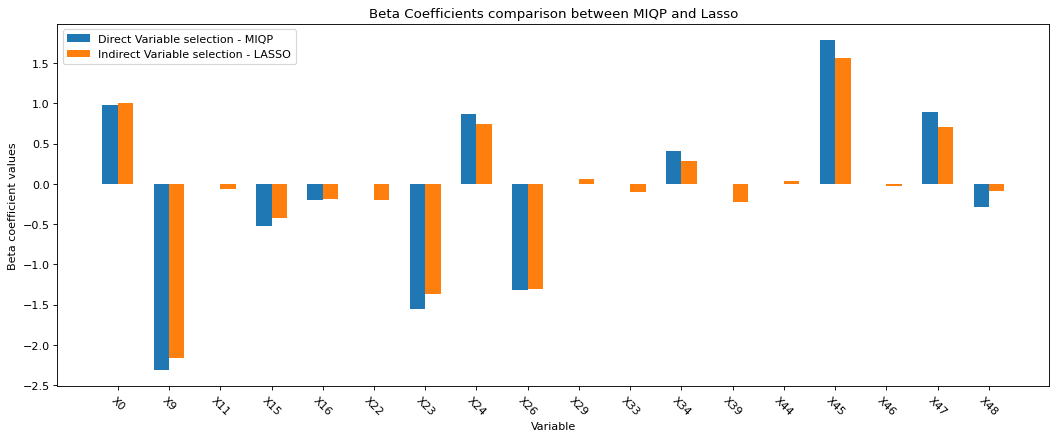

In [32]:
# plotting different firm allocation
plt.figure(figsize=(16, 6), dpi=80)
final_beta_df_viz = beta_df[(beta_df['direct'] != 0) | (beta_df['indirect'] != 0)]

width = 0.3
ind = np.arange(len(final_beta_df_viz))
plt.xticks(ind + width / 2, final_beta_df_viz.index)
plt.bar(ind, final_beta_df_viz['direct'], label='Direct Variable selection - MIQP', width=width)
plt.bar(ind + width, final_beta_df_viz['indirect'], label='Indirect Variable selection - LASSO', width=width)

plt.xlabel('Variable')
plt.xticks(rotation = -45)
plt.ylabel('Beta coefficient values')
plt.title('Beta Coefficients comparison between MIQP and Lasso')
plt.legend()
plt.show()